
## Echo State Networks (ESN)

---

#### **Concept**

An **Echo State Network (ESN)** is a type of **Recurrent Neural Network (RNN)** that uses a **fixed, randomly initialized “reservoir”** of neurons to model temporal dynamics — only the **output weights** are trained.

It belongs to the broader class of **Reservoir Computing** architectures.

---

#### **Core Intuition**

Traditional RNNs (like LSTMs, GRUs) train *all* weights — this is slow and prone to vanishing gradients.
ESNs avoid this by:

* Keeping the recurrent (hidden) connections **fixed and random**,
* Training **only the output layer** (using simple linear regression).

This random recurrent “reservoir” acts as a **dynamic memory** that transforms the input sequence into a rich, high-dimensional temporal representation.
The **“echo”** in *Echo State Network* comes from how the reservoir’s internal states keep a fading memory of past inputs — like echoes fading over time.

---

#### **Architecture Overview**

```
Input  →  Reservoir (fixed RNN)  →  Output (trainable linear readout)
```

![alt text](../../images/esn.png)

| Component        | Description                                                   |
| ---------------- | ------------------------------------------------------------- |
| **Input layer**  | Projects input into the reservoir                             |
| **Reservoir**    | Large, fixed RNN with randomly connected neurons              |
| **Output layer** | Linear model trained to map reservoir states to target output |

---

#### **Mathematical Workflow**

Let:

* $x_t$: input at time *t*
* $h_t$: reservoir state
* $y_t$: output
* $W_{in}, W, W_{out}$: input, recurrent, and output weights

**State update equation:**
$$
h_t = \tanh(W_{in}x_t + W h_{t-1})
$$

**Output:**
$$
y_t = W_{out} [x_t, h_t]
$$

Only $W_{out}$ is trained (using linear regression or ridge regression).
$W$ and $W_{in}$ are fixed random matrices scaled to satisfy the **Echo State Property**.

---

#### **Echo State Property (ESP)**

To ensure stability:

* The influence of old inputs should **fade over time**.
* This requires the **spectral radius** (largest absolute eigenvalue) of $W$ to be **< 1**.

This keeps the reservoir dynamics stable (no exploding activations).

---

#### **Workflow Summary**

| Step | Stage              | Operation                               | Description                          |
| ---- | ------------------ | --------------------------------------- | ------------------------------------ |
| 1    | Initialize         | Randomly set $W_{in}$, $W$          | Create fixed reservoir               |
| 2    | Scale $W$        | Adjust spectral radius < 1              | Ensure echo state property           |
| 3    | Feed data          | Pass sequential input through reservoir | Generate internal states $h_t$     |
| 4    | Collect states     | Store all $h_t$                       | Form feature matrix                  |
| 5    | Train output layer | Solve linear regression for $W_{out}$ | Learn mapping from states to targets |
| 6    | Predict            | Use trained $W_{out}$ for inference   | Fast, no recurrence training         |

---

#### **Intuitive Analogy**

The reservoir acts like a **liquid** that ripples when new inputs are added:

* Each input perturbs the system,
* The ripples (internal activations) encode temporal information,
* The output layer learns to read these ripples to produce predictions.

This is why ESNs are often visualized as a **“liquid state machine.”**

---

#### **Advantages**

| Advantage                      | Explanation                                          |
| ------------------------------ | ---------------------------------------------------- |
| **Fast training**              | Only output weights are trained (simple regression). |
| **No vanishing gradients**     | No backpropagation through time.                     |
| **Good for temporal patterns** | Reservoir captures dynamic system behavior.          |
| **Stable and robust**          | If spectral radius < 1, dynamics stay bounded.       |

---

#### **Disadvantages**

| Disadvantage                                             | Explanation                                                                        |
| -------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **Hyperparameter-sensitive**                             | Performance depends on random initialization, spectral radius, and reservoir size. |
| **Lack of adaptability**                                 | Reservoir is fixed; cannot fine-tune to specific data.                             |
| **Less expressive**                                      | Struggles with highly nonlinear, long-term dependencies.                           |
| **Not ideal for large-scale NLP or deep learning tasks** | Works best for smaller or continuous dynamical systems.                            |

---

#### **When to Use ESNs**

| Use Case                                   | Reason                                                                         |
| ------------------------------------------ | ------------------------------------------------------------------------------ |
| **Time-series forecasting**                | Fast and effective for nonlinear temporal signals (e.g., weather, stock data). |
| **System modeling / control**              | Captures dynamic behaviors of physical systems.                                |
| **Signal processing**                      | Works for temporal feature extraction and denoising.                           |
| **Low-resource environments**              | No GPU training needed.                                                        |
| **When interpretability and speed matter** | Easy to analyze due to linear output layer.                                    |

---

#### **Typical Hyperparameters**

| Hyperparameter               | Description                           | Typical Range |
| ---------------------------- | ------------------------------------- | ------------- |
| **Reservoir size**           | Number of neurons in the reservoir    | 100–1000      |
| **Spectral radius**          | Controls memory length and stability  | 0.8–0.99      |
| **Input scaling**            | Controls input influence on reservoir | 0.1–1.0       |
| **Leak rate**                | Controls update speed of states       | 0.1–1.0       |
| **Regularization (ridge α)** | Stabilizes output weight learning     | 1e−4–1e−2     |

---

---

#### **Comparison with Other RNNs**

| Feature                  | RNN / LSTM / GRU             | ESN                            |
| ------------------------ | ---------------------------- | ------------------------------ |
| **Training**             | Backpropagation through time | Linear regression only         |
| **Trainable parameters** | All weights                  | Only output weights            |
| **Speed**                | Slow                         | Very fast                      |
| **Memory control**       | Learned via gates            | Controlled via spectral radius |
| **Stability**            | Learned                      | Must be tuned manually         |
| **Best for**             | Deep sequence modeling       | Dynamical systems, forecasting |

---

**Summary**

| Aspect            | Description                                                         |
| ----------------- | ------------------------------------------------------------------- |
| **Idea**          | Fixed random reservoir transforms inputs; only output layer learns. |
| **Core property** | Echo State Property ensures stable fading memory.                   |
| **Training**      | Linear regression (no backprop).                                    |
| **Best for**      | Fast, interpretable modeling of time-dependent systems.             |


### Demonstration
---

#### **Cell 1 — Import Dependencies**



In [2]:
# Install if needed:
# !pip install numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt


---

### 🧩 **Cell 2 — Generate Synthetic Time-Series Data**

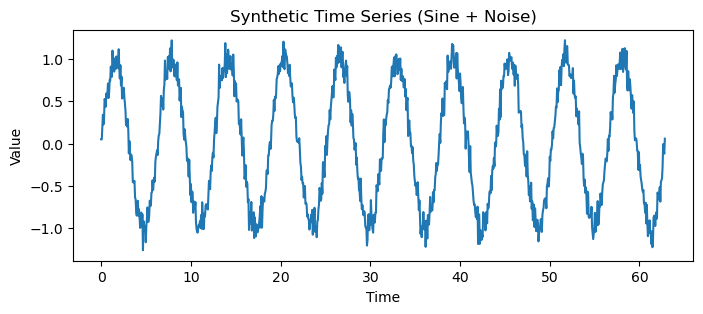

In [3]:
np.random.seed(42)
T = 1000
time = np.linspace(0, 20 * np.pi, T)
data = np.sin(time) + np.random.normal(0, 0.1, T)  # sine wave + noise

plt.figure(figsize=(8, 3))
plt.plot(time, data)
plt.title("Synthetic Time Series (Sine + Noise)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


---

### 🧩 **Cell 3 — Train/Test Split**

In [4]:
split = int(T * 0.8)
train_data = data[:split]
test_data = data[split:]

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")


Train samples: 800, Test samples: 200



---

#### **Cell 4 — Define ESN Helper Functions**



In [5]:

def create_esn(n_inputs, n_reservoir, spectral_radius, input_scaling):
    """
    Creates random input (Win) and reservoir (W) matrices scaled to spectral radius.
    """
    Win = np.random.uniform(-input_scaling, input_scaling, (n_reservoir, n_inputs))
    W = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
    rhoW = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rhoW  # ensure echo state property
    return Win, W


def run_esn(u, Win, W, leak_rate=1.0):
    """
    Runs reservoir dynamics for input sequence u.
    """
    n_reservoir = W.shape[0]
    x = np.zeros((n_reservoir, len(u)))
    for t in range(1, len(u)):
        x[:, t] = (1 - leak_rate) * x[:, t - 1] + leak_rate * np.tanh(Win @ np.array([[u[t]]])[:, 0] + W @ x[:, t - 1])
    return x


def train_esn(u_train, u_test, Win, W, alpha=1e-3):
    """
    Trains ESN output weights using Ridge regression and returns predictions.
    """
    x_train = run_esn(u_train, Win, W)
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train.T, u_train)
    y_pred_train = ridge.predict(x_train.T)

    x_test = run_esn(u_test, Win, W)
    y_pred_test = ridge.predict(x_test.T)
    return y_pred_train, y_pred_test


---

### 🧩 **Cell 5 — Define Hyperparameter Grid**



In [6]:
spectral_radii = [0.8, 0.9, 0.99]
input_scalings = [0.1, 0.5, 1.0]
reservoir_sizes = [100, 200]
alphas = [1e-3, 1e-2]




---

### 🧩 **Cell 6 — Train and Tune ESN Models**



In [7]:

results = []

for sr, scale, size, alpha in itertools.product(spectral_radii, input_scalings, reservoir_sizes, alphas):
    Win, W = create_esn(1, size, sr, scale)
    y_train_pred, y_test_pred = train_esn(train_data, test_data, Win, W, alpha)
    mse = mean_squared_error(test_data, y_test_pred)
    results.append((sr, scale, size, alpha, mse))

results_df = pd.DataFrame(results, columns=["Spectral Radius", "Input Scaling", "Reservoir Size", "Alpha", "Test MSE"])
results_df.sort_values("Test MSE").head()


,Spectral Radius,Input Scaling,Reservoir Size,Alpha,Test MSE
10,0.8,1.0,200,0.001,0.000104
6,0.8,0.5,200,0.001,0.000104
18,0.9,0.5,200,0.001,0.000104
4,0.8,0.5,100,0.001,0.000104
14,0.9,0.1,200,0.001,0.000104




---

### 🧩 **Cell 7 — Display Best Configuration**

In [8]:

best_config = results_df.loc[results_df["Test MSE"].idxmin()]
print("Best ESN Configuration:")
print(best_config)


Best ESN Configuration:
Spectral Radius      0.800000
Input Scaling        1.000000
Reservoir Size     200.000000
Alpha                0.001000
Test MSE             0.000104
Name: 10, dtype: float64




---

#### **Cell 8 — Retrain Best ESN and Visualize Predictions**


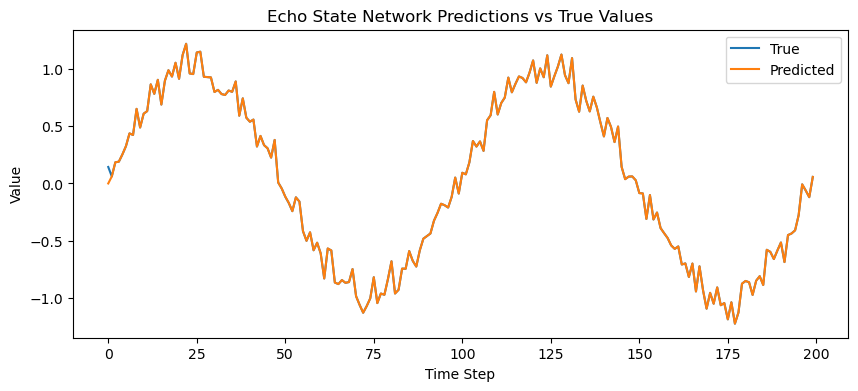

In [9]:
best_sr = best_config["Spectral Radius"]
best_scale = best_config["Input Scaling"]
best_size = int(best_config["Reservoir Size"])
best_alpha = best_config["Alpha"]

# Recreate and retrain ESN with best hyperparameters
Win, W = create_esn(1, best_size, best_sr, best_scale)
y_train_pred, y_test_pred = train_esn(train_data, test_data, Win, W, best_alpha)

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(test_data)), test_data, label="True")
plt.plot(np.arange(len(test_data)), y_test_pred, label="Predicted")
plt.title("Echo State Network Predictions vs True Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()




---

#### **What Happens Here**

| Step | Description                                  |
| ---- | -------------------------------------------- |
| 1    | Random reservoir (fixed) created             |
| 2    | Reservoir state evolves for each input       |
| 3    | States used as features for Ridge regression |
| 4    | Only output weights trained (fast)           |
| 5    | Hyperparameters tuned via grid search        |
| 6    | Best config used to retrain and predict      |

---

#### **Tuning Parameters Summary**

| Parameter               | Role                                   | Good Range |
| ----------------------- | -------------------------------------- | ---------- |
| **Spectral Radius (ρ)** | Controls memory retention              | 0.8–0.99   |
| **Input Scaling**       | Controls input sensitivity             | 0.1–1.0    |
| **Reservoir Size**      | Number of neurons in dynamic reservoir | 100–1000   |
| **Alpha (Ridge)**       | Regularization strength                | 1e−4–1e−2  |

